# Data-Efficient Active Learning (DEAL) example

## Imports

In [8]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from ase import Atom
from ase.io import read,write

sys.path.append("../")
from deal.input import create_deal_input
from deal.utils import average_along_cv,compute_histogram,plumed_to_pandas,paletteFessa,create_chemiscope_input

## Load

### Load trajectory

In [46]:
folder = '../npj_notebooks/notebooks/2_convergence/N2_opes_outputs/'
traj_path = folder+'traj-std-ev10.xyz'

traj = read(traj_path,index=':')
len(traj)

3001

### Load COLVAR (optional)

In [ ]:
colvar_file = folder+'COLVAR'
colvar = None

if colvar_file is not None:
    try:
        colvar = plumed_to_pandas(colvar_file)

        # save colvar into atoms.info
        for i,atoms in enumerate(traj):
            for col in colvar.columns:
                atoms.info['colvar.'+col] = colvar[col].iloc[i]

    except Exception as e:
        print(e)

colvar

## Preprocessing

Pre-selection via query-by-committee (optional)

In [12]:
uncertainty_key = 'force_std_comp_max' # key of array

threshold = 0.09 # None
max_threshold = 3*threshold

if threshold is not None:
    try:
        # define uncertainty of a frame as the max uncertainty on force components
        uncertainty = np.asarray([atoms.get_array(uncertainty_key).max() for atoms in traj])
        # save it in atoms.info
        for i,atoms in enumerate(traj):
            atoms.info['uncertainty'] = uncertainty[i]
            
        preselection = ( uncertainty > threshold ) & ( uncertainty < max_threshold )

        print(f'Preselection by uncertainty: {preselection.sum()}/{len(traj)} frames')

    except Exception as e:
        print('No preselection: uncertainty not found.')
        preselection = np.ones(len(traj),dtype=bool)

Preselection by uncertainty: 1743/3001 frames


Shuffling (reccomended)

In [13]:
# shuffle trajectory
shuffle = True
seed = 42 

idx = np.argwhere(preselection)[:,0]
if shuffle:
    np.random.seed(seed)
    np.random.shuffle(idx)
    print('Shuffled')

traj_input = [traj[i] for i in idx]

Shuffled


Write trajectory

In [14]:
write('All_Data.xyz',traj_input)

## DEAL selection 

#### Create input

Paremeters:
* `config_path`: file which contains the default values for descriptors etc.
* `cutoff`: the cutoff for the construction of the local environments (can be a single value or a matrix )
* `deal_threshold`: the threshold for selecting the new structures

In [15]:
# set DEAL parameters
cutoff = 5
deal_thresholds = [0.05,0.1,0.15]

for deal_threshold in deal_thresholds:
    run_folder=f"./threshold-{deal_threshold:.3f}/"

    create_deal_input('All_Data.xyz',
                    folder=run_folder,
                    config_path='../deal/configs/default.yaml',
                    cutoff = cutoff,
                    threshold = deal_threshold,
                    copy_traj=False) # create a symbolic link in each folder 

[Errno 17] File exists: '../All_Data.xyz' -> './threshold-0.050/All_Data.xyz'
[Errno 17] File exists: '../All_Data.xyz' -> './threshold-0.100/All_Data.xyz'
[Errno 17] File exists: '../All_Data.xyz' -> './threshold-0.150/All_Data.xyz'


### Run DEAL

In [9]:
slurm_script = '../../deal/configs/submit-deal.slurm' # None to run locally

for deal_threshold in deal_thresholds:
    run_folder=f"./threshold-{deal_threshold:.3f}/"

    if slurm_script is not None:
        print(f"cd {run_folder} && sbatch {slurm_script} && cd -")
    else: # execute locally
        print(f"cd {run_folder} && python ../../deal/deal.py input.yaml && cd -")

cd ./threshold-0.050/ && sbatch ../../deal/configs/submit-deal.slurm && cd -
cd ./threshold-0.100/ && sbatch ../../deal/configs/submit-deal.slurm && cd -
cd ./threshold-0.150/ && sbatch ../../deal/configs/submit-deal.slurm && cd -


## Analyze

In [32]:
deal_thresholds = [0.05,0.1,0.15]

traj_deals = {}

print('DEAL Selection')
traj_all = read('All_Data.xyz',index=':')
for deal_threshold in deal_thresholds:
    run_folder=f"threshold-{deal_threshold:.3f}/"
    traj = read(run_folder+'deal_selected.xyz',index=':')
    traj_deals[deal_threshold] = traj
    print(f'Threshold {deal_threshold:.3f}: {len(traj)}/{len(traj_all)} structures')

colors = mpl.colormaps['fessa'](np.linspace(0, 1, len(traj_deals)))

DEAL Selection
Threshold 0.050: 294/1743 structures
Threshold 0.100: 147/1743 structures
Threshold 0.150: 92/1743 structures


Selection curves

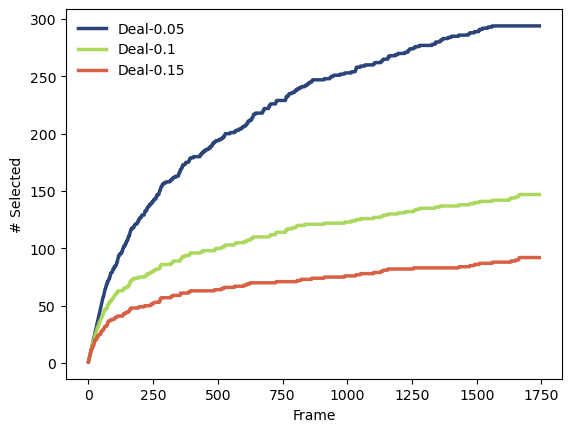

In [33]:
fig, ax = plt.subplots()

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    selected_ids = [ atoms.info['step'] for atoms in traj_deal ]
    selection_curve = [np.sum(np.asarray(selected_ids)<=i) for i in range(len(traj_all))]
    ax.plot(selection_curve,label=f'Deal-{deal_threshold}',linewidth=2.5,alpha=0.95, color=colors[k])

ax.set_xlabel('Frame')
ax.set_ylabel('# Selected')
ax.legend(frameon=False)

Histogram vs CVs

Available CVs: ['colvar.time', 'colvar.coord_Co-Fe', 'colvar.coord_Co-N', 'colvar.coord_Fe-N', 'colvar.dist_N-N', 'uncertainty']


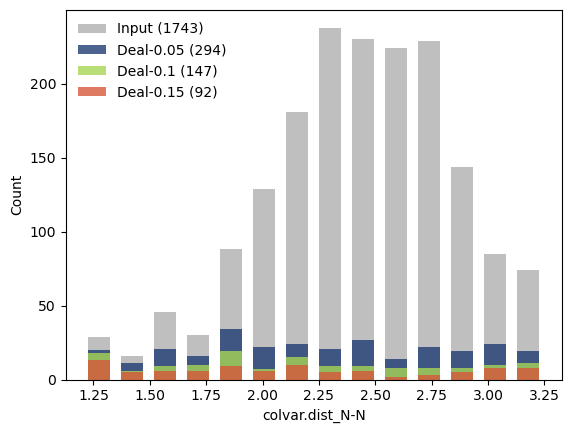

In [41]:
print("Available CVs:",[c for c in traj_all[0].info.keys() ])

cv_name = 'colvar.dist_N-N'

fig, ax = plt.subplots()
cv_all = np.asarray([atoms.info[cv_name] for atoms in traj_all])
bins_cv = np.linspace(cv_all.min(),cv_all.max(),15)
x,h = compute_histogram(cv_all,bins=bins_cv)
ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Input ({len(traj_all)})',alpha=0.5,color='grey',zorder=0)
#for xi,hi in zip(x,h):
    #ax.text(xi,hi+5,f'{hi}', horizontalalignment= 'center', color='grey')

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    cv_deal = np.asarray([atoms.info[cv_name] for atoms in traj_deal])
    x,h = compute_histogram(cv_deal,bins=bins_cv)
    ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Deal-{deal_threshold} ({len(traj_deal)})',alpha=0.8,color=colors[k],zorder=0)
    #for xi,hi in zip(x,h):
        #ax.text(xi-dx/5,hi+5,f'{hi}',color=colors[k])

ax.set_xlabel(cv_name)
ax.set_ylabel('Count')
ax.legend(frameon=False)
plt.show()

View selection via chemiscope

In [ ]:
import chemiscope

deal_threshold = 0.1
run_folder=f"threshold-{deal_threshold:.3f}/"

## if the chemiscope file is not already generated it can be done with the following line
#from deal.utils import create_chemiscope_input
#chemiscope_input = create_chemiscope_input(trajectory = run_folder+'deal_selected.xyz',
#                                           filename=run_folder+'deal_chemiscope.json.gz')

chemiscope.show_input(f'{run_folder}/deal_chemiscope.json.gz')